# Figure 2

CHANGE IN SEMI-MAJOR AXIS: 11.856534749544778 AU


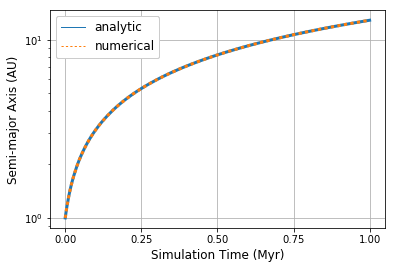

In [8]:
import rebound
import reboundx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

#Unit Converters
au_conv = 1.495978707e11
msun_conv = 1.9885e30
yr_conv = 31557600.0

#Simulation begins here
sim = rebound.Simulation()

sp = sim.particles #simplifies way to access particles parameters 

sim.units = ('yr', 'AU', 'Msun') #changes simulation and G to units of solar masses, years, and AU  
sim.integrator = "whfast" #integrator for sim
sim.dt = .05 #timestep for sim

sim.add(m=1) #adds Sun 
sim.add(a=1, f=0, Omega=0, omega=0, e=0, inc=0, m=0) #adds test particle 

#Moves all particles to center of momentum frame
sim.move_to_com()

#Loads REBOUNDx and Yarkovsky effect into sim    
rebx = reboundx.Extras(sim)
yark = rebx.load_force("yarkovsky_effect")

#Converts units of parameters from m/kg/sec to AU/Msun/yr
density = (3000*au_conv*au_conv*au_conv)/msun_conv
albedo = 0 #we assume the body absorbs all incoming radiation here
c = (2.998e8*yr_conv)/au_conv
lstar = (100000*3.828e26*yr_conv*yr_conv*yr_conv)/(msun_conv*au_conv*au_conv)
radius = 1000/au_conv

#Adds necessary parameters for the Simple Version of the Yarkovsky effect in REBOUNDx
yark.params["lstar"] = lstar
yark.params["yark_c"] = c
sp[1].params["body_density"] = density
sp[1].params["albedo"] = albedo
sp[1].params["yark_flag"] = 1
sp[1].r = radius

rebx.add_force(yark) #adds Yarkovsky effect to the sim

tmax= 1e6 # in yrs

a_start = 1 #starting semi-major axis for the asteroid
        
changing_a = [1] #will record the semi-major axis of the asteroid over the course of the sim
    
while sim.t < tmax: #determines how many years the sim lasts
        sim.step() #moves sim forward a time step
        sim.integrator_synchronize() #synchronizes all changes in the particles during the sim
        changing_a.append(sp[1].a) #adds semi-major axis to list after each time step    


a_final = sp[1].a #semi-major axis of asteroid after the sim    
                      
print("CHANGE IN SEMI-MAJOR AXIS:", a_final-a_start, "AU") #prints difference between the intitial and final semi-major axes of asteroid

G = 4*np.pi**2
mass = (4/3)*np.pi*(radius**3)*density
time = np.linspace(0, sim.t, len(changing_a))
a_2 = [] #change in semi-major axis from the analytic equation

#calculates distance data from analytic equation 
for i in time:
    dist = ((3*(1-albedo)*radius**2*lstar*i)/(32*2*np.pi*mass*c)+a_start**(3/2))**(2/3)
    a_2.append(dist)

    
#Plot Creation
fig, ax1 = plt.subplots()

ax1.plot(np.linspace(0, sim.t/1e6, len(changing_a)),
         changing_a, '-', color = 'tab:blue', linewidth=3)
ax1.plot(time/1e6, a_2, ':', color = 'tab:orange', linewidth=3)

plt.grid()
ax1.set_xlabel('Simulation Time (Myr)', fontsize='large')
ax1.set_ylabel('Semi-major Axis (AU)', fontsize='large')
ax1.xaxis.set_ticks(np.arange(0, 1.25, .25))
ax1.set_yscale('log')

first_legend_elements = [Line2D([0], [0], color='tab:blue', alpha=1.0, lw=1.0, label='analytic', linewidth=5,),
                         Line2D([0], [0], color='tab:orange', alpha=1.0, lw=1.0, label='numerical', linewidth=5, linestyle=':' )]                                  
first_legend = plt.legend(handles=first_legend_elements, framealpha = 1, fontsize='large', loc = 'upper left')
plt.gca().add_artist(first_legend)


plt.savefig('images/fig2.eps', bbox_inches='tight', pad_inches=0.01)
plt.savefig('images/fig2.pdf', bbox_inches='tight', pad_inches=0.01)
plt.savefig('images/fig2.png', bbox_inches='tight', dpi=300)

plt.show()